In [153]:
import random as rd
import numpy as np
import copy


#generates a random sequence of bitstream of any length
def rand_bitstream(bitlength):
    bitstream = ""
    for i in range(bitlength):
        temp = str(rd.randint(0,1))
        bitstream += temp
    return bitstream

#Converts an integer to its binary string equivalent
def intToBin(value,size):
    return bin(value)[2:].zfill(size)

#Converts a numpy bit array to a bit string
def npStr(nump):
    outStr = ""
    for value in nump:
        outStr+=str(value)
    return outStr
#Converts a numpy bit array to an int
def npInt(nump):
    return int(npStr(nump),2)

#Converts an int to its numpy bit array equivalent
def intToNp(val, size):
    strTemp = intToBin(val,size)
    npOut = np.array([9]*size)
    for i in range(size):
        npOut[i] = int(strTemp[i])
    return npOut

#Converts a bit string to its numpy bit array equivalent
def binToNp(binStr):
    size = len(binStr)
    npOut = np.array([9]*size)
    for i in range(size):
        npOut[i] = int(binStr[i])
    return npOut



In [154]:
#IDcheck function
def verifyID(ID, ID_guess, runs):
    print("Ran for ",runs, "protocol runs")
    return (int(ID,2) - int(npStr(ID_guess),2))==0

In [162]:
#Runs an MMAP protocol
def protocolRun(oracle):
    size = len(oracle)//5
    MOD_SIZE = 2**size
    
    #this is our ID, never changing, always the same
    ID_MMAP_str ='101110011011001011100100001101010011110010001001000101001101001001110010110100100001011001110010'
    
    #Our ID with double the length (size is 96*2)
    if(size != 96):
        for i in range(0,size,96):
            ID_MMAP_str = ID_MMAP_str+ID_MMAP_str
    ID_MMAP = int(ID_MMAP_str,2)
    
    IDP_MMAP_str, K_1_MMAP_str, K_2_MMAP_str, K_3_MMAP_str, K_4_MMAP_str = [oracle[i:i+size] for i in range(0,len(oracle),size)]
    
    IDP_MMAP = int(IDP_MMAP_str,2)
    K_1_MMAP = int(K_1_MMAP_str,2)
    K_2_MMAP = int(K_2_MMAP_str,2)
    K_3_MMAP = int(K_3_MMAP_str,2)
    K_4_MMAP = int(K_4_MMAP_str,2)
    
    
    n1_MMAP = int(rand_bitstream(size),2)
    n2_MMAP = int(rand_bitstream(size),2)
    
    A_int_MMAP = (IDP_MMAP ^ K_1_MMAP ^ n1_MMAP)%MOD_SIZE
    B_int_MMAP = ((IDP_MMAP & K_2_MMAP) | n1_MMAP)%MOD_SIZE
    C_int_MMAP = (IDP_MMAP + K_3_MMAP + n2_MMAP)%MOD_SIZE
    D_int_MMAP = ((IDP_MMAP | K_4_MMAP) & n2_MMAP)%MOD_SIZE
    E_int_MMAP = ((IDP_MMAP + ID_MMAP) ^ n1_MMAP)%MOD_SIZE
    
    NextIDP_int_MMAP = ((IDP_MMAP + (n1_MMAP ^ n2_MMAP)) ^ ID_MMAP)%MOD_SIZE
    NextK_1_int_MMAP = (K_1_MMAP ^ n1_MMAP ^ (K_3_MMAP + ID_MMAP))%MOD_SIZE
    NextK_2_int_MMAP = (K_2_MMAP ^ n2_MMAP ^ (K_4_MMAP + ID_MMAP))%MOD_SIZE
    NextK_3_int_MMAP = ((K_3_MMAP ^ n1_MMAP) + (K_1_MMAP ^ ID_MMAP))%MOD_SIZE
    NextK_4_int_MMAP = ((K_4_MMAP ^ n1_MMAP) + (K_2_MMAP ^ ID_MMAP))%MOD_SIZE
    
    A_MMAP = intToBin(A_int_MMAP, size)
    B_MMAP = intToBin(B_int_MMAP, size)
    C_MMAP = intToBin(C_int_MMAP, size)
    D_MMAP = intToBin(D_int_MMAP, size)
    E_MMAP = intToBin(E_int_MMAP, size)
    
    NextIDP_MMAP = intToBin(NextIDP_int_MMAP, size)
    NextK_1_MMAP = intToBin(NextK_1_int_MMAP, size)
    NextK_2_MMAP = intToBin(NextK_2_int_MMAP, size)
    NextK_3_MMAP = intToBin(NextK_3_int_MMAP, size)
    NextK_4_MMAP = intToBin(NextK_4_int_MMAP, size)
    
    NextIDP_K_MMAP = NextIDP_MMAP + NextK_1_MMAP + NextK_2_MMAP + NextK_3_MMAP + NextK_4_MMAP
    
    return A_MMAP,B_MMAP,C_MMAP,D_MMAP,E_MMAP,NextIDP_K_MMAP








In [163]:
#Breaks an input into 4 bit chunks, xoring the chunks' bits to quarter size
def Fp_func(input1):
    chunks = [input1[i:i+4] for i in range(0,len(input1),4)]
    final_output_str = ''
    for chunk in chunks:
        final_output_str += str(int(chunk[0])^int(chunk[1])^int(chunk[2])^int(chunk[3]))
    return final_output_str
    
print(Fp_func("101101101000"))

101


In [164]:
#Finds and outputs the ID of an MMAP RFID system, given only intercepted comms between reader and tag
def MMAP_attack(oracle):
    IDP_K_str = oracle
    SIZE = len(oracle)//5
    garbage = "" #Used to collect useless information, and ignore it
    
    #Finding the first IDP we will use, so that it works from any random valid IDP
    #We don't care about the previous A-E, since we are assuming that we don't know the IDP used for that interaction
    garbage,garbage,garbage,garbage,garbage,IDP_next = protocolRun(IDP_K_str)
    
    #Initializing our ID output to all 9s, to represent that we don't know what it is
    ID = np.array([9]*SIZE)
    
      #E_XOR IDP pair array
    EX = []
    runtime = 1
    #Until we return a complete ID, keep making MMAP exchanges
    while(1):
        runtime+=1
        #Initializing our IDP
        IDP = binToNp(IDP_next[0:SIZE])
        #Initializing A-E, and the next IDP
        A,B,C,D,E,IDP_next = protocolRun(IDP_next)
        
        #Initializing n1 to all 9s
        n1 = np.array([9]*SIZE)
        
        #Finding all knowable values of n1
        i = 0
        phi = (IDP == 0)
        tau = (IDP == 1)
        B = binToNp(B)
        n1[phi] = B[phi]
        negIDP = intToNp(npInt(1 - IDP)+1, SIZE)
        
        #Initializing E XOR n1 to 9s
        E_xor_n1 = np.array([9]*SIZE)
        
        #Calculating knowable values of E XOR n1
        E = binToNp(E)
        E_xor_n1[phi] = E[phi] ^ n1[phi]
        EX.append(np.array([E_xor_n1, negIDP]))
        for exorpair in EX:
            carry = 0
            for i in range(SIZE-1,-1,-1):
                if ID[i] == 9: break
                val = ID[i] + exorpair[1,i] + carry
                if exorpair[0,i] == 9:
                    exorpair[0,i] = (val)%2
                #Confirm this is right
                carry = exorpair[0,i] + exorpair[1,i] + carry > 1
            #Calculating knowable values of the ID
            carry = 0
            for i in range(SIZE-1,-1,-1):
                if exorpair[0,i] == 9: break
                val = exorpair[0,i] + exorpair[1,i] + carry
                if ID[i] == 9:
                    ID[i] = (val)%2
                carry = val > 1
            #If ID's most significant bit is found, return it
            if ID[0] != 9:
                return ID, runtime
#I wanted to define this so that you wouldn't get a random starting IDP_K data stream Every time 
# you did a protocal run.

IDP_K_str = '111111111000100100001110010001011010011111100010010000000111100101111101110110101101000011000111101101001011100000111010110011100001101110111001111111110100010010010001100000011101000110001001000101101001110010000010111110000011001100001100111101101011000010111100110101100110101000110101110001011010111110101010111100101001111001100101000111010110111101111100100011100010101011000010111110011111110011100000111010011011011100111000110100100110100110011011001011111101011011010110'

#The double length version
IDP_K_str_long = '111111111000100100001110010001011010011111100010010000000111100101111101110110101101000011000111101101001011100000111010110011100001101110111001111111110100010010010001100000011101000110001001000101101001110010000010111110000011001100001100111101101011000010111100110101100110101000110101110001011010111110101010111100101001111001100101000111010110111101111100100011100010101011000010111110011111110011100000111010011011011100111000110100100110100110011011001011111101011011010110111111111000100100001110010001011010011111100010010000000111100101111101110110101101000011000111101101001011100000111010110011100001101110111001111111110100010010010001100000011101000110001001000101101001110010000010111110000011001100001100111101101011000010111100110101100110101000110101110001011010111110101010111100101001111001100101000111010110111101111100100011100010101011000010111110011111110011100000111010011011011100111000110100100110100110011011001011111101011011010110'
ID_guess,runtime = MMAP_attack(IDP_K_str)
ID_actual = '101110011011001011100100001101010011110010001001000101001101001001110010110100100001011001110010'
ID_actual_long = '101110011011001011100100001101010011110010001001000101001101001001110010110100100001011001110010101110011011001011100100001101010011110010001001000101001101001001110010110100100001011001110010'
print(verifyID(ID_actual, ID_guess, runtime))
ID_guess,runtime = MMAP_attack(IDP_K_str_long)
print(verifyID(ID_actual_long, ID_guess, runtime))

Ran for  16 protocol runs
True
Ran for  22 protocol runs
True


In [158]:
class EMAPoracle2:
    def __init__(self,ID):
        size = len(ID)
        temp = rand_bitstream(size*5)
        idp_emap_str, k1_str, k2_str, k3_str, k4_str = [temp[i:i+size] for i in range(0,len(temp),size)]
        
        self.IDP = int(idp_emap_str,2)
        
        self.ID = int(ID,2)
                
        #create randomized n values 
        self.n1 = int(rand_bitstream(size),2)
        self.n2 = int(rand_bitstream(size),2)
        
        #create the integer Ks in here
        self.k1 = int(k1_str,2)
        self.k2 = int(k2_str,2)
        self.k3 = int(k3_str,2)
        self.k4 = int(k4_str,2)
        self.mod = 2**size
        self.size = size
    
    #Updates all EMAP secrets for both reader and tag
    def update(self):
        ID_str = intToBin(self.ID, self.size)
        id_str1 = ID_str[:self.size//2]
        id_str2 = ID_str[self.size//2:]
        
        k1fp = Fp_func(intToBin(self.k1, self.size))
        k2fp = Fp_func(intToBin(self.k2, self.size))
        k3fp = Fp_func(intToBin(self.k3, self.size))
        k4fp = Fp_func(intToBin(self.k4, self.size))
        
        sub_new_k1 = (id_str1 + k4fp + k3fp)
        sub_new_k2 = (k1fp + k4fp + id_str2)
        sub_new_k3 = (id_str1 + k4fp + k2fp)
        sub_new_k4 = (k3fp + k1fp + id_str2)
        
        new_k1int = int(sub_new_k1,2)
        new_k2int = int(sub_new_k2,2)
        new_k3int = int(sub_new_k3,2)
        new_k4int = int(sub_new_k4,2)
        
        self.IDP = (self.IDP ^ self.n2 ^ self.k1)
        self.k1 = (self.k1 ^ self.n2 ^ new_k1int)
        self.k2 = (self.k2 ^ self.n2 ^ new_k2int)
        self.k3 = (self.k3 ^ self.n1 ^ new_k3int)
        self.k4 = (self.k4 ^ self.n1 ^ new_k4int)
        
        self.n1 = int(rand_bitstream(self.size),2)
        self.n2 = int(rand_bitstream(self.size),2)

In [159]:
#take in oracle, return a, b, c and oracle (idp)     
def protocolRun1(oracle):
        
    a_int = (oracle.IDP ^ oracle.k1 ^ oracle.n1)#%oracle.mod
    b_int = ((oracle.IDP | oracle.k2) ^ oracle.n1)#%oracle.mod
    c_int = (oracle.IDP ^ oracle.k3 ^ oracle.n2)#%oracle.mod
    
    a = intToBin(a_int, oracle.size)
    b = intToBin(b_int, oracle.size)
    c = intToBin(c_int, oracle.size)
    assert(a_int^oracle.k1^oracle.IDP == oracle.n1)
    IDP = intToBin(oracle.IDP,oracle.size)
    
    return a, b, c, IDP
        
def impersonate_reader(a, b, c, oracle):
    #calc n1, n2
    n1 = a ^ oracle.k1 ^ oracle.IDP 
    n2 = c ^ oracle.IDP ^ oracle.k3
    
    ki = oracle.k1 ^ oracle.k2 ^ oracle.k3 ^ oracle.k4
        
    d_int = ((oracle.IDP & oracle.k4) ^ n2)#%oracle.mod 
    e_int = ((oracle.IDP & n1 | n2) ^ oracle.ID ^ ki)#%oracle.mod
    
    
    d = intToBin(d_int, oracle.size)
    e = intToBin(e_int, oracle.size)
    
    #TODO - check if this is right
    if b == (oracle.IDP | oracle.k2) ^ n1:
        return d, e
    else:
        assert(1==0)

In [160]:
def stage1and2(oracle):
    
    #Initializing n1, n2, A-E, K1-K4 to all 9s
    n1 = np.array([9]*oracle.size)
    n2 = np.array([9]*oracle.size)
    A = np.array([9]*oracle.size)
    B = np.array([9]*oracle.size)
    C = np.array([9]*oracle.size)
    D = np.array([9]*oracle.size)
    E = np.array([9]*oracle.size)
    E_prime = np.array([9]*oracle.size)
    K1 = np.array([9]*oracle.size)
    K2 = np.array([9]*oracle.size)
    K3 = np.array([9]*oracle.size)
    K4 = np.array([9]*oracle.size)
    IDP = np.array([9]*oracle.size)
    
    
    #Getting A,B,C, IDP
    A_str,B_str,C_str, IDP_int = protocolRun1(oracle)

    #Converting all to numpy arrays
    for i in range(oracle.size):
        A[i] = int(A_str[i])
        B[i] = int(B_str[i])
        C[i] = int(C_str[i])
        IDP[i] = int(IDP_int[i])
    #initing phi and tau bitmasks
    phi = (IDP == 0)
    tau = (IDP == 1)
    
    
    #finding all bits of n1 where IDP==1
    n1[tau] = 1-B[tau]
    
    #finding all bits of K1 where IDP==0
    K1[tau] = A[tau]^n1[tau]^IDP[tau]
    
    #Making a modified version of A,B, where all bits at tau are xor'd with IDP
    A_prime = copy.deepcopy(A)
    A_prime[tau] = A_prime[tau]^IDP[tau]

    B_prime = copy.deepcopy(B)
    B_prime[tau] = B_prime[tau]^IDP[tau]
    
    #converting A',B' to binary strings
    A_prime_str = ""
    B_prime_str = ""
    for i in range(oracle.size):
        A_prime_str += str(A_prime[i])
        B_prime_str += str(B_prime[i])
        
    
    #Getting D, E'
    D_str,E_prime_str = impersonate_reader(int(A_prime_str,2),int(B_prime_str,2),int(C_str,2),oracle)
    
    
    
    #Getting E
    E_str = impersonate_reader(int(A_str,2),int(B_str,2),int(C_str,2), oracle)[1]
    
    #Converting all to numpy arrays
    for i in range(oracle.size):
        D[i] = int(D_str[i])
        E[i] = int(E_str[i])
        E_prime[i] = int(E_prime_str[i])
        
    #finding all bits of n2 where IDP==0
    n2[phi] = D[phi]
    
    #Finding rest of n2 using E' and E
    n2[tau] = E[tau] == E_prime[tau]
    
    #Finding K3
    K3 = C^IDP^n2
    
    #Finding K4,K1 where IDP==1
    K4[tau] = D[tau]^n2[tau]
    
    K1[tau] = A[tau]^n1[tau]^IDP[tau]
    
    return n1,n2,A,B,C,D,E,K1,K2,K3,K4,IDP

In [161]:
def EMAP_attack(oracle):
    ID = np.array([9]*oracle.size)
    
    #initializing the values
    n1,n2,A,B,C,D,E,K1,K2,K3,K4, IDP = stage1and2(oracle)
    
    
#     breakpoint()
    oracle.update()
    n1_newest,n2_newest,A_newest,B_newest,C_newest,D_newest,E_newest,K1_newest,K2_newest,K3_newest,K4_newest,IDP_newest = stage1and2(oracle)
    #Keeping track of number of protocol runs
    numRuns = 0
    while((ID == 9).any()):
        
        #Finding values at n+1
        n1_new,n2_new,A_new,B_new,C_new,D_new,E_new,K1_new,K2_new,K3_new,K4_new,IDP_new = n1_newest,n2_newest,A_newest,B_newest,C_newest,D_newest,E_newest,K1_newest,K2_newest,K3_newest,K4_newest,IDP_newest
        #initializing phi, tau
        phi = (IDP == 0)
        tau = (IDP == 1)
        
        #Finding K1_n
        K1 = IDP_new ^ IDP ^ n2
        
        #Finding n1_n
        n1 = A ^ IDP ^ K1
        
        #Finding K2[IDP==0]_n
        K2[phi] = B[phi] ^ n1[phi]
        
        #Finding IDP_n+2 to calculate K1_n+1
        
        oracle.update()
        n1_newest,n2_newest,A_newest,B_newest,C_newest,D_newest,E_newest,K1_newest,K2_newest,K3_newest,K4_newest,IDP_newest = stage1and2(oracle)
        #Incrementing run count
        numRuns+=1
        
        #Calculating all of K1_n+1
        K1_new = IDP_newest ^ IDP_new ^ n2_new
        
        #Calculating all of n1_n+1
        n1_new = A_new ^ IDP_new ^ K1_new
        
        #Calculating left half of ID tag (technically only need to do once, but nice to check)
        ID[:oracle.size//2] = K1_new[:oracle.size//2] ^ K1[:oracle.size//2] ^ n2[:oracle.size//2]
        
        #Calculating K2_n+1
        K2_new[IDP_new == 0] = B_new[IDP_new == 0] ^ n1_new[IDP_new == 0]
        
        #Setting bitmasks for phi & phi', tau & tau'
        phi_comb = ((IDP_new[oracle.size//2:] == 0) & (IDP[oracle.size//2:] == 0))
        tau_comb = ((IDP_new[oracle.size//2:] == 1) & (IDP[oracle.size//2:] == 1))
        
        #Setting as many of the right half bits of ID tag as possible
        ID[oracle.size//2:][phi_comb] = K2_new[oracle.size//2:][phi_comb] ^ n2[oracle.size//2:][phi_comb] ^ K2[oracle.size//2:][phi_comb]
        ID[oracle.size//2:][tau_comb] = K4_new[oracle.size//2:][tau_comb] ^ n1[oracle.size//2:][tau_comb]^ K4[oracle.size//2:][tau_comb]
        
        #Iterating the variables forward
        IDP = IDP_new
        IDP_new = IDP_newest
        n1,n2,A,B,C,D,E,K1,K2,K3,K4 = n1_new,n2_new,A_new,B_new,C_new,D_new,E_new,K1_new,K2_new,K3_new,K4_new
    return ID, numRuns

#Testing with normal, 96 bit length EMAP
testOracle = EMAPoracle2('101110011011001011100100001101010011110010001001000101001101001001110010110100100001011001110010')

#Storing cracked ID, # of runs
ID_guess, runs = EMAP_attack(testOracle)

print(IDcheck(intToBin(testOracle.ID, testOracle.size), ID_guess, runs))

#Double length ID
testOracle = EMAPoracle2('101110011011001011100100001101010011110010001001000101001101001001110010110100100001011001110010101110011011001011100100001101010011110010001001000101001101001001110010110100100001011001110010')
ID_guess, runs = EMAP_attack(testOracle)
print(IDcheck(intToBin(testOracle.ID, testOracle.size), ID_guess, runs))

Ran for  7  runs
True
Ran for  9  runs
True


In [178]:
from tempfile import TemporaryFile
MMAP_runtimes = np.array([-1]*15)
EMAP_runtimes = np.array([-1]*15)
for i in range(1,16):
    ID_temp = rand_bitstream(96*i)
    MMAP_oracle_temp = rand_bitstream(96*i*5)
    MMAP_runtimes[i-1] = MMAP_attack(MMAP_oracle_temp)[1]
    EMAP_runtimes[i-1] = EMAP_attack(EMAPoracle2(ID_temp))[1]
    print("Run number ", i)



Run number  1
Run number  2
Run number  3
Run number  4
Run number  5
Run number  6
Run number  7
Run number  8
Run number  9
Run number  10
Run number  11
Run number  12
Run number  13
Run number  14
Run number  15


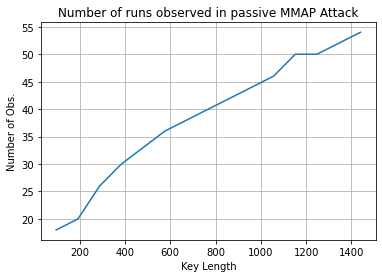

In [179]:
x = np.arange(96,96*16,96)
import matplotlib.pyplot as plt

plt.plot(x,MMAP_runtimes)
plt.grid()
plt.xlabel("Key Length")
plt.ylabel("Number of Obs.")
plt.title("Number of runs observed in passive MMAP Attack")
plt.show()

Run number  1
Run number  2
Run number  3
Run number  4
Run number  5
Run number  6
Run number  7
Run number  8
Run number  9
Run number  10
Run number  11
Run number  12
Run number  13
Run number  14
Run number  15
Run number  16
Run number  17
Run number  18
Run number  19
Run number  20
Run number  21
Run number  22
Run number  23
Run number  24
Run number  25
Run number  26
Run number  27
Run number  28
Run number  29
Run number  30
Run number  31
Run number  32
Run number  33
Run number  34
Run number  35
Run number  36
Run number  37
Run number  38
Run number  39
Run number  40
Run number  41
Run number  42
Run number  43
Run number  44
Run number  45
Run number  46
Run number  47
Run number  48
Run number  49
Run number  50


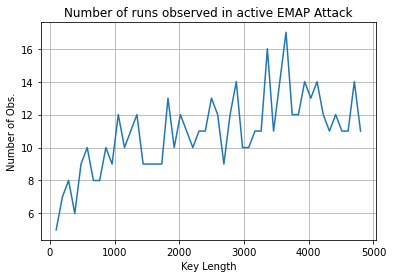

In [181]:
EMAP_runtimes = np.array([-1]*50)
for i in range(1,51):
    ID_temp = rand_bitstream(96*i)
    EMAP_runtimes[i-1] = EMAP_attack(EMAPoracle2(ID_temp))[1]
    print("Run number ", i)

x = np.arange(96,96*51,96)
plt.plot(x,EMAP_runtimes)
plt.grid()
plt.xlabel("Key Length")
plt.ylabel("Number of Obs.")
plt.title("Number of runs observed in active EMAP Attack")
plt.show()